# Dataset

In [ ]:
!wget https://people.csail.mit.edu/torralba/code/spatialenvelope/spatial_envelope_256x256_static_8outdoorcategories.zip

--2024-10-01 08:25:13--  https://people.csail.mit.edu/torralba/code/spatialenvelope/spatial_envelope_256x256_static_8outdoorcategories.zip
Resolving people.csail.mit.edu (people.csail.mit.edu)... 128.52.131.233
Connecting to people.csail.mit.edu (people.csail.mit.edu)|128.52.131.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135033638 (129M) [application/zip]
Saving to: ‘spatial_envelope_256x256_static_8outdoorcategories.zip’

spatial_envelope_25 100%[===================>] 128.78M  14.5MB/s    in 8.8s    

2024-10-01 08:25:22 (14.6 MB/s) - ‘spatial_envelope_256x256_static_8outdoorcategories.zip’ saved [135033638/135033638]



In [ ]:
!unzip spatial_envelope_256x256_static_8outdoorcategories.zip

Archive:  spatial_envelope_256x256_static_8outdoorcategories.zip
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_arnat59.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_art1130.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_art294.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_art487.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_bea1.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_bea10.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_bea14.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_bea2.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_bea20.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_bea24.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_bea26.jpg  
  inflating: spatial_envelope

In [ ]:
import os
import shutil

def organize_images_by_class(source_dir, target_dir):


  if not os.path.exists(target_dir):
    os.makedirs(target_dir)

  for filename in os.listdir(source_dir):
    if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):  # Assumindo que as imagens são .jpg
      class_name = filename.split('_')[0]
      class_dir = os.path.join(target_dir, class_name)

      if not os.path.exists(class_dir):
        os.makedirs(class_dir)

      source_path = os.path.join(source_dir, filename)
      target_path = os.path.join(class_dir, filename)
      shutil.copy(source_path, target_path)


# Define o diretório de origem e destino
source_dir = "/content/spatial_envelope_256x256_static_8outdoorcategories"
target_dir = "/content/imagens_por_classe"

# Organiza as imagens
organize_images_by_class(source_dir, target_dir)


# CNN - Autoencoder

Neste caso, as caracteristicas sao extraidas conforme erro da reconstrucao

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image

# Definição do modelo Autoencoder
class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),      # -> [16, 126, 126]
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3),     # -> [32, 124, 124]
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3),     # -> [64, 122, 122]
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3),    # -> [128, 120, 120]
            nn.ReLU(True),
        )

        # Camada Linear para reduzir a dimensão para 512
        self.fc = nn.Linear(128 * 120 * 120, 512)  # Flattened output to 512 dimensions

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3),   # -> [64, 122, 122]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3),    # -> [32, 124, 124]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3),    # -> [16, 126, 126]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=3),     # -> [3, 128, 128]
            nn.Sigmoid()  # Normalizando a saída entre 0 e 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x_flattened = x.view(x.size(0), -1)  # Flatten antes da camada linear
        embeddings = self.fc(x_flattened)  # Passa pela camada linear
        x = x.view(x.size(0), 128, 120, 120)  # Reverter para o formato antes do decoder
        x = self.decoder(x.view(x.size(0), 128, 120, 120))  # Decodifica
        return x, embeddings



# Transformações de imagem
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensiona para 128x128
    transforms.ToTensor(),            # Converte para tensor
])



In [ ]:
from torch.utils.data import random_split, DataLoader
# Carregando os dados
data_dir = '/content/imagens_por_classe'

# Defina a proporção de treino e teste
train_ratio = 0.8  # 80% para treino, 20% para teste
test_ratio = 1 - train_ratio

# Carregue o dataset com ImageFolder
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Calcula o tamanho de treino e teste
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Divide o dataset em treino e teste
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Cria DataLoader para treino e teste
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [ ]:
# Instanciando o modelo, loss function e optimizer
model = CNN_Autoencoder().cuda()  # Mover para GPU se disponível
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Treinando o modelo
num_epochs = 10  # Ajuste conforme necessário
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.cuda()  # Mover para GPU se disponível

        # Forward
        output, embeddings = model(img)  # Agora retorna também as embeddings
        loss = criterion(output, img)

        # Backward e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.0364
Epoch [2/10], Loss: 0.0162
Epoch [3/10], Loss: 0.0105
Epoch [4/10], Loss: 0.0080
Epoch [5/10], Loss: 0.0083
Epoch [6/10], Loss: 0.0051
Epoch [7/10], Loss: 0.0050
Epoch [8/10], Loss: 0.0049
Epoch [9/10], Loss: 0.0044
Epoch [10/10], Loss: 0.0032


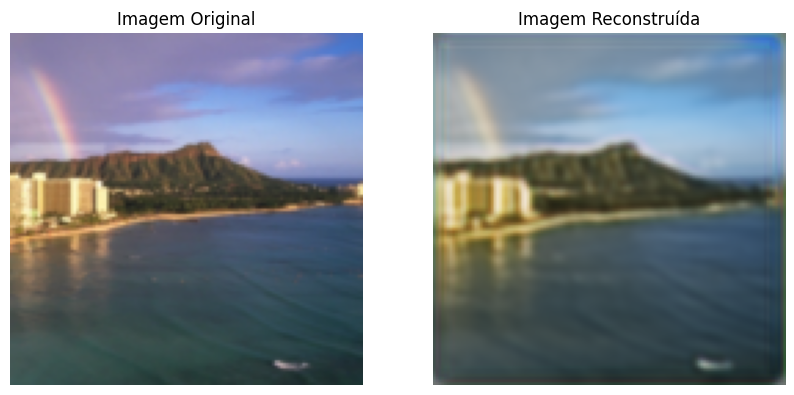

In [ ]:
import matplotlib.pyplot as plt

def display_image_and_reconstruction(model, image_path):
    # Carregar a imagem
    image = Image.open(image_path).convert('RGB')  # Converte para RGB caso não seja
    image = transform(image).unsqueeze(0)  # Aplica as transformações e adiciona uma dimensão extra para o batch

    # Colocar o modelo em modo de avaliação
    model.eval()

    # Mover a imagem para o mesmo dispositivo que o modelo
    device = next(model.parameters()).device
    image = image.to(device)

    with torch.no_grad():  # Desativa o cálculo de gradientes
        reconstructed_image, _ = model(image)  # Passa pela rede para obter a imagem reconstruída

    # Remover a dimensão extra da imagem reconstruída
    reconstructed_image = reconstructed_image.squeeze(0)

    # Converter as imagens para numpy arrays para exibição
    original_image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()  # De [C, H, W] para [H, W, C]
    reconstructed_image_np = reconstructed_image.permute(1, 2, 0).cpu().numpy()  # De [C, H, W] para [H, W, C]

    # Exibir as imagens
    plt.figure(figsize=(10, 5))

    # Imagem original
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np)
    plt.title("Imagem Original")
    plt.axis("off")

    # Imagem reconstruída
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image_np)
    plt.title("Imagem Reconstruída")
    plt.axis("off")

    plt.show()

# Exemplo de uso
# Certifique-se de que o modelo já esteja treinado antes de usar esta função
image_file_path = "/content/imagens_por_classe/coast/coast_art294.jpg"
display_image_and_reconstruction(model, image_file_path)


In [ ]:
# Testando a extração de embeddings

# Função para extrair embeddings
def extract_embeddings(model, image_path, transform):
    model.eval()
    image = Image.open(image_path).convert("RGB")  # Garantir que a imagem seja RGB
    image = transform(image).unsqueeze(0)  # Adiciona batch dimension
    with torch.no_grad():
        _, embeddings = model(image.cuda())  # Mover para GPU se disponível
    return embeddings

embedding = extract_embeddings(model, '/content/imagens_por_classe/coast/coast_arnat59.jpg', transform)
print("Shape of extracted embeddings:", embedding.shape)

Shape of extracted embeddings: torch.Size([1, 512])


In [ ]:
embedding.cpu().numpy()

array([[ 1.00505359e-01, -3.35616261e-01, -6.44015297e-02,
        -8.58963206e-02, -7.07737431e-02,  1.41878158e-01,
        -1.44404083e-01,  1.68206424e-01, -2.87589245e-02,
         7.26506263e-02,  7.20519051e-02, -7.99121782e-02,
         3.04998830e-02, -5.51070869e-02, -4.58506979e-02,
         1.22658715e-01, -8.31148103e-02,  2.34473318e-01,
        -5.99194095e-02, -3.45420018e-02, -1.55860588e-01,
         1.66341022e-01, -2.43743107e-01, -1.09469801e-01,
        -2.59341478e-01, -2.29979858e-01, -5.95370587e-03,
         1.17292158e-01, -1.61560908e-01,  2.74236232e-01,
         1.07117392e-01,  1.07505694e-01,  1.04492139e-02,
        -1.05150295e-02, -1.79783404e-01, -4.11609858e-02,
         2.90920377e-01, -3.20734262e-01,  2.89040525e-02,
        -1.45116793e-02, -2.75393903e-01,  4.33075204e-02,
        -2.36223072e-01, -1.89120248e-01,  2.43204400e-01,
         5.73514625e-02,  1.25346228e-01, -1.87377483e-01,
         9.94673371e-02, -1.53071597e-01, -1.13118365e-0

In [ ]:

# Recuperar os nomes das imagens para treino
L_imgs_treino = [dataset.imgs[i][0] for i in train_loader.dataset.indices]

# Recuperar os nomes das imagens para teste
L_imgs_teste = [dataset.imgs[i][0] for i in test_loader.dataset.indices]


In [ ]:
X_train = []
y_train = []
for img in L_imgs_treino:
  X_train.append(extract_embeddings(model, img, transform).cpu().numpy()[0])
  y_train.append(img.split('/')[3]) # ajustar aqui se vc tem outros diretorios

# aqui usamos nosso autoencoder para gerar embeddings de imagens nao vistas no treino
X_test = []
y_test = []
for img in L_imgs_teste:
  X_test.append(extract_embeddings(model, img, transform).cpu().numpy()[0])
  y_test.append(img.split('/')[3])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

neigh = KNeighborsClassifier(n_neighbors=3,metric="cosine")
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       coast       0.38      0.69      0.49        85
      forest       0.39      0.71      0.50        69
     highway       0.45      0.83      0.59        60
  insidecity       0.50      0.04      0.07        56
    mountain       0.60      0.17      0.26        72
 opencountry       0.44      0.54      0.49        72
      street       0.88      0.38      0.53        60
tallbuilding       0.86      0.09      0.17        64

    accuracy                           0.45       538
   macro avg       0.56      0.43      0.39       538
weighted avg       0.55      0.45      0.39       538



# CNN para Classificação de Imagens

Neste caso, as características são extraídas conforme erro do classificador.



In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Definir as transformações
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Carregar o dataset completo
data_dir = "/content/imagens_por_classe"
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Obter todos os índices do dataset
indices = list(range(len(dataset)))
labels = [dataset.targets[i] for i in indices]

# Dividir o dataset em treino e teste de forma estratificada (preserva a distribuição de classes)
train_indices, test_indices = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)

# Criar Subsets para treino e teste
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Criar DataLoaders para treino e teste
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:
# CNN de Classificação
class CNN_Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Classifier, self).__init__()

        # Encoder (extrator de features)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # -> [16, 128, 128]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> [16, 64, 64]

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # -> [32, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> [32, 32, 32]

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # -> [64, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # -> [64, 16, 16]
        )

        # Camada fully connected para classificação
        self.fc = nn.Sequential(
            nn.Linear(64 * 16 * 16, 512),  # Reduzir as features para 512 dimensões (embeddings)
            nn.ReLU(),
            nn.Linear(512, num_classes)  # Camada final para classificação
        )

    def forward(self, x):
        # Extração de features
        x = self.encoder(x)
        x_flattened = x.view(x.size(0), -1)  # Achatar antes de passar pela camada fully connected

        # Embeddings intermediárias
        embeddings = self.fc[0](x_flattened)  # Obter as embeddings (saída da primeira camada fully connected)

        # Classificação
        out = self.fc[1](embeddings)  # Obter a classificação final

        return out, embeddings

# Definir dispositivo (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inicializar o modelo, critério de perda e otimizador
num_classes = len(dataset.classes)  # Número de classes baseado nos subdiretórios
model = CNN_Classifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Função para treinar o modelo
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zerar os gradientes
            optimizer.zero_grad()

            # Forward pass
            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            # Backward pass e otimização
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Treinar o modelo
train_model(model, train_loader, criterion, optimizer, device, num_epochs=50)


Epoch [1/50], Loss: 4.5483
Epoch [2/50], Loss: 4.0876
Epoch [3/50], Loss: 3.8935
Epoch [4/50], Loss: 3.7423
Epoch [5/50], Loss: 3.6795
Epoch [6/50], Loss: 3.6532
Epoch [7/50], Loss: 3.5668
Epoch [8/50], Loss: 3.4850
Epoch [9/50], Loss: 3.4400
Epoch [10/50], Loss: 3.4481
Epoch [11/50], Loss: 3.3230
Epoch [12/50], Loss: 3.3279
Epoch [13/50], Loss: 3.3341
Epoch [14/50], Loss: 3.2556
Epoch [15/50], Loss: 3.2125
Epoch [16/50], Loss: 3.1752
Epoch [17/50], Loss: 3.1766
Epoch [18/50], Loss: 3.2034
Epoch [19/50], Loss: 3.1411
Epoch [20/50], Loss: 3.1717
Epoch [21/50], Loss: 3.1777
Epoch [22/50], Loss: 3.1200
Epoch [23/50], Loss: 3.0891
Epoch [24/50], Loss: 3.1184
Epoch [25/50], Loss: 3.1169
Epoch [26/50], Loss: 3.1137
Epoch [27/50], Loss: 3.1003
Epoch [28/50], Loss: 3.0781
Epoch [29/50], Loss: 3.1003
Epoch [30/50], Loss: 3.0614
Epoch [31/50], Loss: 3.0855
Epoch [32/50], Loss: 3.0976
Epoch [33/50], Loss: 3.1099
Epoch [34/50], Loss: 3.0850
Epoch [35/50], Loss: 3.1126
Epoch [36/50], Loss: 3.8836
E

In [ ]:
from sklearn.metrics import classification_report

# Função para avaliar o modelo e gerar o classification report
def evaluate_model(model, test_loader, device):
    model.eval()  # Colocar o modelo em modo de avaliação
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, preds = torch.max(outputs, 1)

            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Gerar o classification report
    report = classification_report(y_true, y_pred, target_names=dataset.classes)
    print(report)

# Avaliar o modelo e gerar o classification report
evaluate_model(model, test_loader, device)


              precision    recall  f1-score   support

       coast       0.21      0.82      0.33        72
      forest       0.68      0.80      0.74        66
     highway       0.68      0.75      0.72        52
  insidecity       0.00      0.00      0.00        62
    mountain       0.00      0.00      0.00        75
 opencountry       0.59      0.83      0.69        82
      street       0.00      0.00      0.00        58
tallbuilding       0.00      0.00      0.00        71

    accuracy                           0.41       538
   macro avg       0.27      0.40      0.31       538
weighted avg       0.27      0.41      0.31       538



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from PIL import Image

def generate_embeddings(model, image_path, transform, device):

    # Carregar e transformar a imagem
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Adicionar a dimensão do batch (1, C, H, W)

    # Mover a imagem para o dispositivo (CPU ou GPU)
    image = image.to(device)

    # Colocar o modelo em modo de avaliação
    model.eval()

    with torch.no_grad():
        # Apenas passar pelo encoder para obter as embeddings
        _, embeddings = model(image)

    # Converter as embeddings para CPU e numpy para uso posterior
    embeddings = embeddings.cpu().numpy()

    return embeddings


In [ ]:
generate_embeddings(model, '/content/imagens_por_classe/coast/coast_arnat59.jpg', transform, device)

array([[ 24.59412  , -60.419025 ,  10.021533 , -10.787771 ,  -8.3631935,
         -7.7412643,  -8.463522 ,  -8.702221 , -11.492314 , -12.404406 ,
        -11.887111 , -10.878742 ,  -8.132088 , -11.4581585, -12.329727 ,
        -12.46242  , -10.642569 , -12.664244 , -12.031179 , -12.49331  ,
        -10.784268 , -12.761128 ,  -9.738485 ,  -6.9546103, -12.379133 ,
        -12.044499 ,  -7.5722   , -12.902641 , -12.245509 , -12.3658285,
        -12.913032 , -12.324821 , -12.3660145, -12.831455 , -12.312761 ,
         -7.4813704,  -6.7848935,  -9.104365 , -11.995172 ,  -8.194461 ,
         -8.911183 , -10.248287 , -11.832465 , -11.851358 , -12.554706 ,
         -6.902205 , -15.066005 , -12.206716 , -12.642776 , -12.803552 ,
         -9.021907 , -12.506581 , -11.47222  , -11.744908 , -12.840223 ,
         -9.432237 ,  -9.364519 , -12.144255 , -12.579669 , -12.493856 ,
        -11.515228 , -11.016641 , -12.722273 , -12.169609 , -11.125834 ,
        -12.661579 , -18.218176 , -10.146657 , -12.

In [ ]:

# Recuperar os nomes das imagens para treino
L_imgs_treino = [dataset.imgs[i][0] for i in train_loader.dataset.indices]

# Recuperar os nomes das imagens para teste
L_imgs_teste = [dataset.imgs[i][0] for i in test_loader.dataset.indices]


In [ ]:
X_train = []
y_train = []
for img in L_imgs_treino:
  X_train.append(generate_embeddings(model, img, transform, device)[0])
  y_train.append(img.split('/')[3]) # ajustar aqui se vc tem outros diretorios

X_test = []
y_test = []
for img in L_imgs_teste:
  X_test.append(generate_embeddings(model, img, transform, device)[0])
  y_test.append(img.split('/')[3])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

neigh = KNeighborsClassifier(n_neighbors=3,metric="cosine")
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       coast       0.78      0.79      0.79        72
      forest       0.80      0.77      0.78        66
     highway       0.84      0.71      0.77        52
  insidecity       0.33      0.42      0.37        62
    mountain       0.55      0.47      0.50        75
 opencountry       0.67      0.73      0.70        82
      street       0.57      0.55      0.56        58
tallbuilding       0.47      0.45      0.46        71

    accuracy                           0.61       538
   macro avg       0.63      0.61      0.62       538
weighted avg       0.62      0.61      0.62       538

